In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, copy, os, shutil
from tqdm.notebook import tqdm
import seaborn as sns
from importlib import reload

import GridWorldHelpers as gwh
import GridWorldTests as gwt

Load and visualize baseline grid world, world with normal pond, world with overflow pond in terms of their  (mean **rewards**)

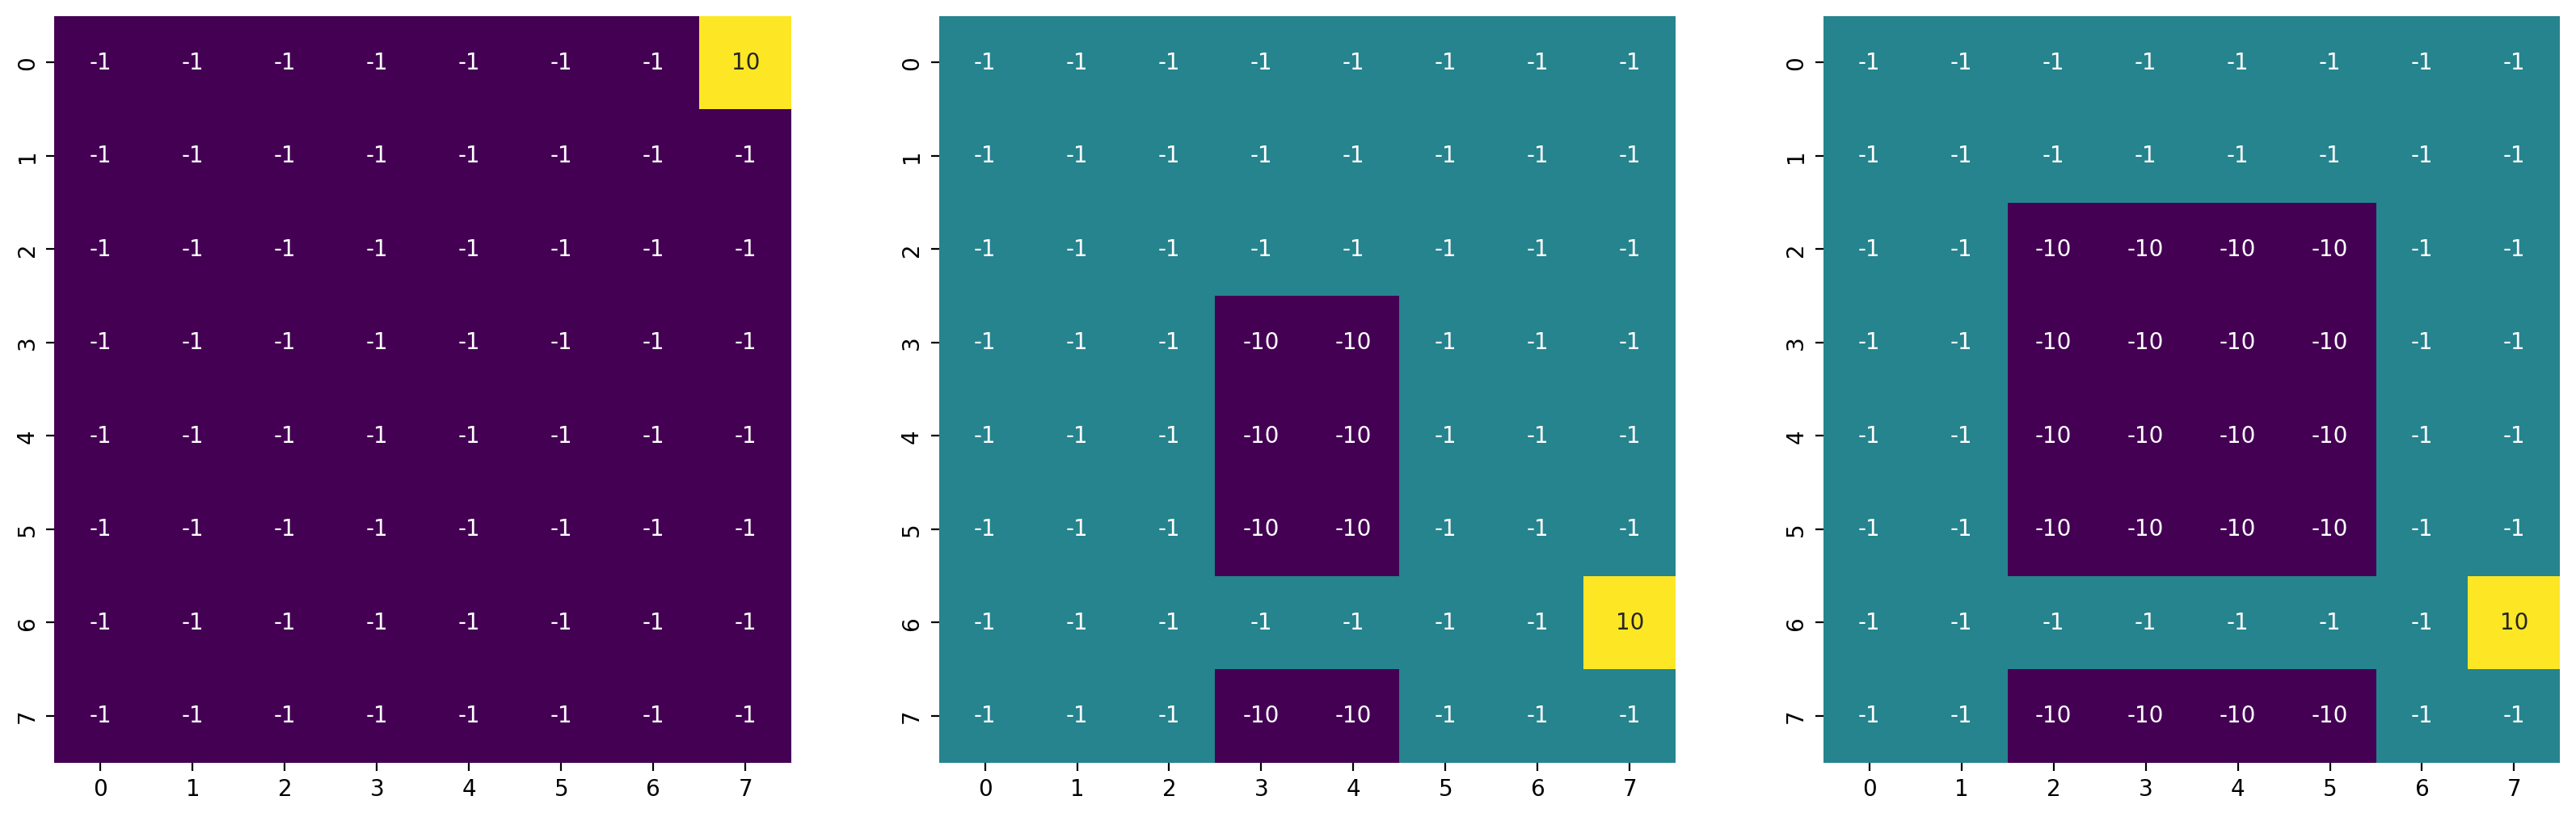

In [3]:
reload(gwh)
gw0, gw1, gw2 = gwh.build_grids(d=8)
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))
gwh.visualize_reward_grid(gw0, ax[0])
gwh.visualize_reward_grid(gw1, ax[1])
gwh.visualize_reward_grid(gw2, ax[2])

Obtain and visualize the colors grids for each of the grid worlds

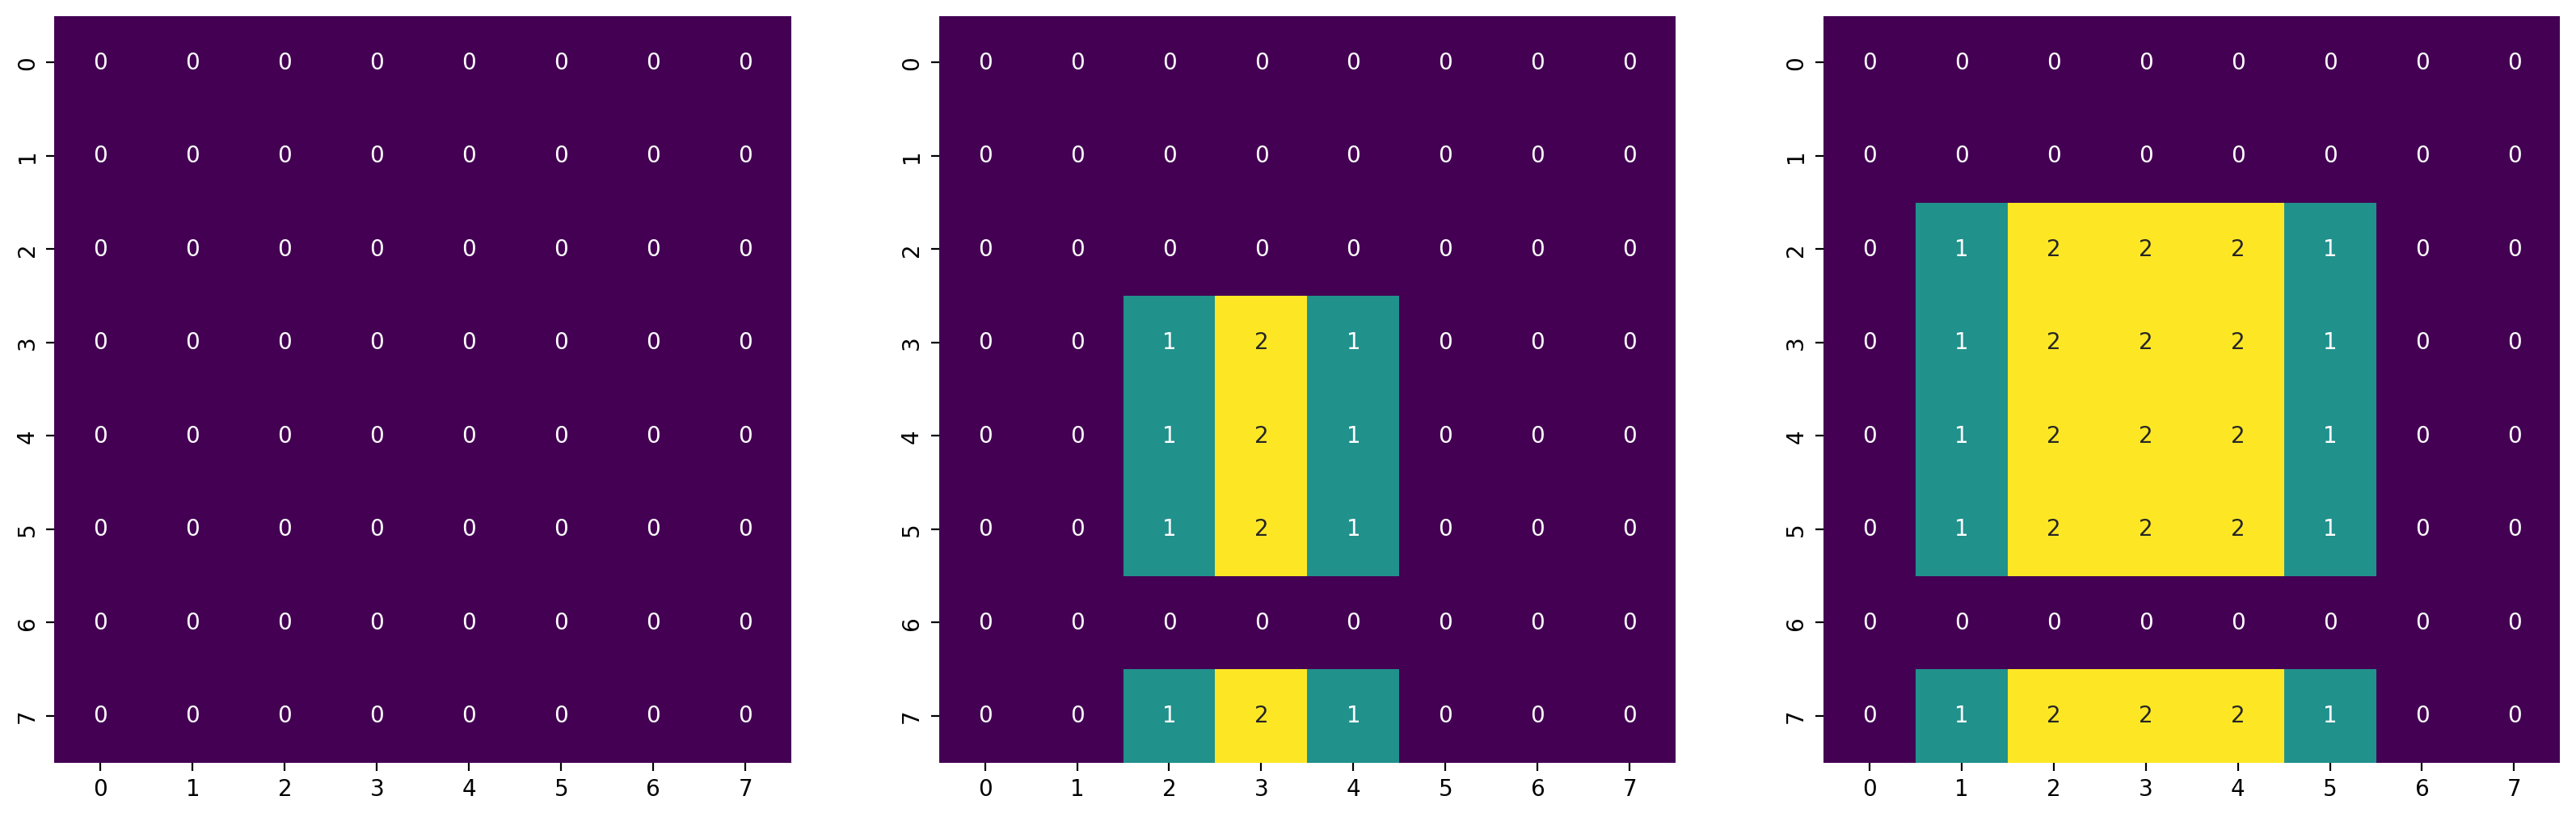

In [4]:
# make the color-grid for GridWorld1
gw0_colors = gwh.make_gw_colors(gw0) 
gw1_colors = gwh.make_gw_colors(gw1)
gw2_colors = gwh.make_gw_colors(gw2)

fig, ax = plt.subplots(1, 3, dpi=200, figsize=(20, 6))
gwh.visualize_reward_grid(gw0_colors, ax[0])
gwh.visualize_reward_grid(gw1_colors, ax[1])
gwh.visualize_reward_grid(gw2_colors, ax[2])

### Parameters and initialization

* **TODO** function which initializes agent location
* for now just setting all to 0.5

In [6]:
p_switch = 0.5 #water stochasticity
p_wind_i = 0.5 #probability of wind at each step
p_wind_j = 0.5
ce = 0 #start at current environment 1

## Procedure

At each time $t$

1. Run ``gwh.get_environment()`` with parameter ``p_overflow`` to determine if pond has overflowed or not (**water stochasticity**).

   * Note: for baseline environment, there is no pond and p is set to 0 
   * I made it so that overflow is markovian with $p(new|current)=p$ and $p(current|current)=p$. That ways there's more of a MDP type thing to learn.

   
2. Using ``gwh.sync_color``, obtain color for current location and update True State

3. **TODO** Using some missing data function, determine agent's observed state

4. **Agent**: given observed state ``Ostate``, previous state and previous action, any relevant objects learned from the history, run ``Learner()`` to output an action ``a``

5. **System** given true state ``Tstate`` and action ``a``,

* generate next true $(x,y)$ (stochastic due to **wind**), **but** not yet updating color because environment might change (e.g., based on current green, you decide to go right but by the time you get there, your next location actually is flooded)
 


In [10]:
reload(gwh)

# set-up the possible environments
environments = {
                0: [gw1,gw1_colors], #baseline
                1: [gw2, gw2_colors] #flooding
               }

# pick current environment 
ce = gwh.get_environment(ce, p_switch)

# given pick, get the reward grid and the color grid to use for this step
gw = environments[ce][0]
gw_colors = environments[ce][1]

# we know current (x,y) from a previous step  - for now, pretend it is this
# get color from current environment
Tstate = np.array([1,1,np.nan]) #(x,y green) # true state
Tstate = gwh.sync_color(Tstate, gw_colors)

#TODO: missing data mechanism applied to determine observed state
Ostate = None

#TODO: learning algorithm to pick an action, for now pretend it's up
a = (0,1)

# Implement move but we don't know color this move will result in yet
# Also, possibly there is some wind blowing us off course
Tstate_new = gwh.true_move(Tstate, a, gw, gw_colors, p_wind_i, p_wind_j)

print(Tstate, Tstate_new)

[1. 1. 0.] [ 0.  2. nan]


# Missing data functions 


In [165]:
reload(gwt)
gwt.test_miss_mech()

All tests passed


In [166]:
reload(gwh)
theta_dict = {0: np.array([.1,.1,.1]),
                   1: np.array([0.0,0.0,0.0]),
                   2: np.array([.4,.4,.4])}
i_range = (3,5); j_range = (3,5)
thetas_in = np.array([.1,.1,.1])
thetas_out = np.array([0.0,0.0,0.0]) 

#Example calls to each
state = np.array([1,1,1])
gwh.MCAR(state,np.array([0 ,0,0]))
gwh.Mcolor(state,theta_dict)
gwh.Mfog(state, i_range = i_range, j_range = j_range, thetas_in = thetas_in, thetas_out = thetas_out)

array([1., 1., 1.])

In [13]:
# put "fog" in a region governed by {i_range x j_range}. If you are in that region, 
# Mfog is MAR if theta_{1j} = theta_{2j} = 0 (i.e, x,y are observed for all timesteps), else NMAR
def Mfog(state, i_range, j_range, thetas_inregion, thetas_outregion):
    
    # default to not being in the region
    inregion = False
    
    # check if we're in the fog region or not
    if np.clip(a=state[0], a_min=i_range[0], a_max=i_range[1]) == state[0]:
        if np.clip(a=state[1], a_min=j_range[0], a_max=j_range[1]) == state[1]:
            inregion = True
            
    # figure out what thetas to use + apply the MCAR
    thetas = thetas_inregion if inregion else thetas_outregion
    po_state = MCAR(state, thetas)

# TODO - move this into a test notebook

In [14]:
# try all possible actions
for a in list(action_descs.keys()):
    
    # try a test-case
    gw = np.zeros((d,d))

    # initialize our state randomly
    state = np.array([4, 9, 1])
    gw[state[0], state[1]] = +100
    
    # get our new state
    new_state = true_move(state, a, gw, gw1_colors)
    gw[new_state[0], new_state[1]] = 50
    
    sns.heatmap(gw, cbar=False, cmap="viridis")
    plt.title(action_descs[a])
    plt.show()

NameError: name 'action_descs' is not defined

# 4/8/2024 Notes
1. It's possible we'll increase pond penalty to $-20$ or more.

In [ ]:
'''
# size of our setup:
1. |A| = 9
2. |S| \leq 8*8*3 = 192 (assuming d=8)

# missing data imputation mechanisms. Our wishlist is to learn
1. S_{t+1} | S_t, A_t # has size \leq 50 * 64 * 9, note the sparsity.
2. S_{t+1,j} | S_t, A_t, S_{t+1,-j} # has size 3*64*9*64
    
    
# baselines
1. Just use the most recent fully-observed state as our current state.
2. Choose action completely at random and only learn from complete cases.
3. Treating any-missing as a separate state.
'''

# data structure for S_{t+1} | S_t, A_t (standard)
Trans_stan = {}

# data structure forb S_{t+1,j} | S_t, A_t, S_{t+1,-j} (mice)
Trans_mice = {"x" : {}, "y" : {}, "z" : {}}

'''
# can update above data structures, 
a) only fully-observed
b) if partially-observed, update only entries corresponding to partially-observed.

*note that in partially-observed case, we will do voting-based action selection.
*we will update A COMMON Tran_stan and Trans_mice with update counter 1/K for each MI imputer, +1 for full obs.
*Try mixing of chains avs. "sync" up from complete states. Might need a mix-frequency parameter.
*note that mixing of chains could be somewhat similar effect to mixing of Q functions.
''''''

In [ ]:
'''
Q-update step:
Q(S_t^obs, S_t^miss(k), A_t) <- (current) + \frac{\alpha}{K}[R_{t+1} + \gamma \max_a Q(S_{t+1}^{obs}, S_{t+1}^(k), a) - current]

'''

$$Q(S_t^{obs}, S_t^{miss,(k)}, A_t) \leftarrow Q(S_t^{obs}, S_t^{miss,(k)}, A_t) + \frac{\alpha}{K}\left[R_{t+1} + \gamma \max_a Q(S_{t+1}^{obs}, S_{t+1}^{(k)}, a) - Q(S_t^{obs}, S_t^{miss,(k)}, A_t) \right]$$

In [ ]:
# things we want to learn
Trans_stan, Trans_mice, Q

# loop for each episode
for epi_idx in range(episodes):
    
    # initialize our FULLY-OBSERVED state at time 0
    init_state
    
    # for each step of episode, i.e., until we hit the +10
    while true_state != terminal_state:
        
        # choose action based on voting-based ensemble (if necessary), 
        A = get_action()
        
        # simulate pond flooding vs. not flooding to change dynamics.
        ce = get_environment
        gw = 
        gw_colors = 
        TState = take_action(Tstateold, A)
        
        # environment outputs + we observe R_{t+1}, S_{t+1}^{obs}, record true state ofc
        R = get_reward(gw)
        OState = get_ostate(Tstate, mechanism) 
        
        # make our imputations on S_{t+1}
        S_imp = get_imputations(Ostate, Tstandard, Tmice)
        
        # update our Q functions, Trans_stan, Trans_mice
        Q = update_Q(S_imp, R, A, Q)
        Trans_stan = update_Tstan(S_imp)
        Trans_mice = update_Tmice(S_imp)
        
        # set current state as the previous new state (including consideration of obs. vs. missing)
        

# List of cases to possibly look at

Missing data mech
1. Basic MAR with all same probability
2. MAR under different \theta rates

Some things to think about
* Initializing transitions with 0 values vs positive values / with or without logical constraints
* Whether agent has access to logical constraints like "if I move right, I know it won't move me more than 2 steps" or not
* If agent knew the NMAR mechanism, could do MLE type stuff but we would only do this for comparison since more realistic scenario is agent does not know the missing data mechanism

